In [9]:
import os
from pathlib import Path
import logging
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import hamming_loss, make_scorer

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass
from capstone.features import Features
from capstone.evaluation import CustomEvaluation
from capstone.utils.constants import (
    TEXT,
    TARGET,
    SPLIT,
    DEVELOP,
    TEST
)

sns.set_style("darkgrid")
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

In [2]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(3)

,Text,Standard mapping?
0,General Quality System Requirements […] Genera...,[regulatory standards management]
1,General Quality System Requirements […] Manage...,"[quality planning, quality management]"
2,General Quality System Requirements […] Manage...,[quality management]


In [3]:
features = Features(config)
df_features = features.build(df)

2022-10-31 18:40:24,631 - capstone.utils.utils - INFO - func:clean took: 3.73 sec
2022-10-31 18:40:25,389 - capstone.utils.utils - INFO - func:fit took: 4.49 sec
2022-10-31 18:40:27,667 - capstone.utils.utils - INFO - func:clean took: 2.28 sec
2022-10-31 18:40:27,968 - capstone.utils.utils - INFO - func:transform took: 2.58 sec
2022-10-31 18:40:27,969 - capstone.utils.utils - INFO - func:fit_transform took: 7.07 sec
2022-10-31 18:40:28,242 - capstone.utils.utils - INFO - func:clean took: 0.27 sec
2022-10-31 18:40:28,287 - capstone.utils.utils - INFO - func:transform took: 0.32 sec
2022-10-31 18:40:28,331 - capstone.utils.utils - INFO - func:build took: 7.45 sec


In [4]:
df_features.head(3)

,Text,Standard mapping?,acquisition and divestiture,audit inspection,calibration,capa,change control,change controls,clinical research,controled substances,...,word__unit generally shared,word__use device,word__used manufacture,word__used manufacturing,word__used production,word__user person,word__validation study,word__way ensures,word__written procedure,Split
0,drug product general design formal stability s...,[stability programs],0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Development
1,quality control quality assurance management q...,[production process controls],0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Development
2,manufacturing control packaging operation ensu...,[labeling and packaging operations],0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Development


Feature Length

In [5]:
print(f"Length of features: {len(features.vectorizer.get_feature_names_out())}")

Length of features: 531


In [ ]:
dev = df_features[df_features[SPLIT].isin([DEVELOP])].copy()
X_dev = dev[features.vectorizer.get_feature_names_out()].copy()
Y_dev = dev[features.mlb.classes_].copy()

test = df_features[df_features[SPLIT].isin([TEST])].copy()
X_test = test[features.vectorizer.get_feature_names_out()].copy()
Y_test = test[features.mlb.classes_].copy()

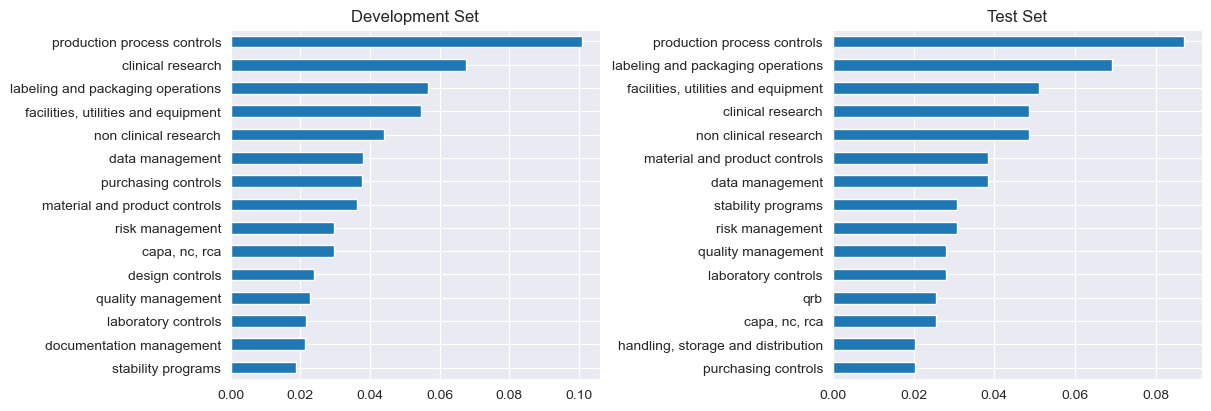

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

dev[TARGET] \
.apply(lambda x: ", ".join(sorted(x))) \
.value_counts(normalize=True) \
.head(15) \
.sort_values() \
.plot(kind="barh", ax=ax[0])

test[TARGET] \
.apply(lambda x: ", ".join(sorted(x))) \
.value_counts(normalize=True) \
.head(15) \
.sort_values() \
.plot(kind="barh", ax=ax[1])

ax[0].set_title("Development Set")
ax[1].set_title("Test Set")
plt.show();

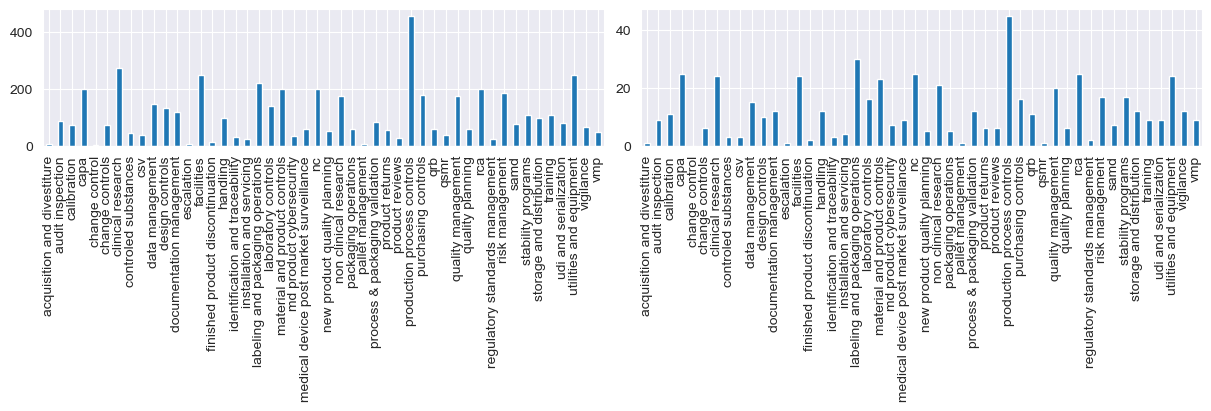

In [8]:
# plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
Y_dev.sum(axis=0).plot.bar(ax=ax[0]);
Y_test.sum(axis=0).plot.bar(ax=ax[1]);

In [12]:
eval = CustomEvaluation()
score = make_scorer(eval.hamming_loss, greater_is_better=False)

In [13]:
params = {
    'estimator__n_estimators': [i for i in range(50, 225, 25)],
    'estimator__max_depth': [10, 20, 30, 40, 50],
    'estimator__max_features': ["sqrt", "log2"],
    "estimator__class_weight": ["balanced_subsample"]
}
rf_classifier = MultiOutputClassifier(RandomForestClassifier())

# ratios = dev.shape[0] / dev[features.mlb.classes_].sum(axis=0)
# ratios = round(ratios).astype(int)
# weights = [{0: 1, 1: ratios[i]} for i in range(len(features.mlb.classes_))]

clf = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=params,
    scoring=score,
    cv=5,
    return_train_score=False,
    verbose=10
)

clf.fit(X_dev, Y_dev)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START estimator__class_weight=balanced_subsample, estimator__max_depth=50, estimator__max_features=sqrt, estimator__n_estimators=125
[CV 1/5; 1/10] END estimator__class_weight=balanced_subsample, estimator__max_depth=50, estimator__max_features=sqrt, estimator__n_estimators=125;, score=-0.026 total time=  52.9s
[CV 2/5; 1/10] START estimator__class_weight=balanced_subsample, estimator__max_depth=50, estimator__max_features=sqrt, estimator__n_estimators=125
[CV 2/5; 1/10] END estimator__class_weight=balanced_subsample, estimator__max_depth=50, estimator__max_features=sqrt, estimator__n_estimators=125;, score=-0.025 total time=  50.4s
[CV 3/5; 1/10] START estimator__class_weight=balanced_subsample, estimator__max_depth=50, estimator__max_features=sqrt, estimator__n_estimators=125
[CV 3/5; 1/10] END estimator__class_weight=balanced_subsample, estimator__max_depth=50, estimator__max_features=sqrt, estimator__n_esti

RandomizedSearchCV(cv=5,
                   estimator=MultiOutputClassifier(estimator=RandomForestClassifier()),
                   param_distributions={'estimator__class_weight': ['balanced_subsample'],
                                        'estimator__max_depth': [10, 20, 30, 40,
                                                                 50],
                                        'estimator__max_features': ['sqrt',
                                                                    'log2'],
                                        'estimator__n_estimators': [50, 75, 100,
                                                                    125, 150,
                                                                    175, 200]},
                   scoring=make_scorer(hamming_loss, greater_is_better=False),
                   verbose=10)

In [10]:
### Random search over a bigger space -- don't run
# params = {
#     'estimator__n_estimators': [i for i in range(50, 250, 25)],
#     "estimator__criterion": ["gini", "entropy", "log_loss"],
#     'estimator__max_depth': [10, 20, 30, 40, 50],
#     'estimator__max_features': ["sqrt", "log2"],
#     "estimator__class_weight": ["balanced_subsample", "balanced"],
#     "estimator__max_samples": [.6, .7, 1.0]
# }
# rf_classifier = MultiOutputClassifier(RandomForestClassifier())

# # ratios = dev.shape[0] / dev[features.mlb.classes_].sum(axis=0)
# # ratios = round(ratios).astype(int)
# # weights = [{0: 1, 1: ratios[i]} for i in range(len(features.mlb.classes_))]

# clf = RandomizedSearchCV(
#     estimator=rf_classifier,
#     param_distributions=params,
#     n_iter=100,
#     scoring=score,
#     cv=5,
#     return_train_score=False,
#     verbose=10,
#     n_jobs=6
# )

# clf.fit(X_dev, Y_dev)

In [14]:
clf.best_estimator_.get_params()

{'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': 'balanced_subsample',
 'estimator__criterion': 'gini',
 'estimator__max_depth': 20,
 'estimator__max_features': 'sqrt',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 125,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                        n_estimators=125),
 'n_jobs': None}

In [15]:
feature_importances = []

for forest in clf.best_estimator_.estimators_:
    feature_importances.append(forest.feature_importances_)

feature_importances = np.mean(feature_importances, axis=0)

scores_, labels_ = map(
    list,
    zip(*sorted(
        list(zip(feature_importances, features.vectorizer.get_feature_names_out())),
        key=lambda x: x[0],
        reverse=True
    ))
)
labels_ = [x.split("__")[1] for x in labels_]

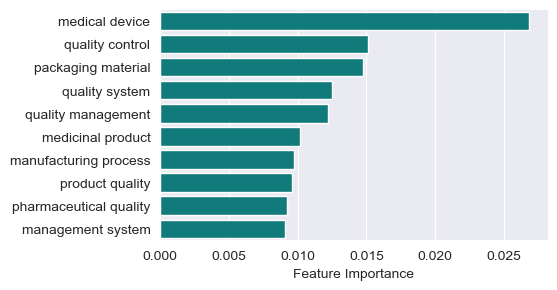

In [16]:
plt.figure(figsize=(5,3))
sns.barplot(x=scores_[:10], y=labels_[:10], color="darkcyan")
plt.xlabel("Feature Importance")
plt.show();

In [18]:
rf_dev_pred = clf.best_estimator_.predict(X_dev)
rf_test_pred = clf.best_estimator_.predict(X_test)

print(f"Random Forest Development Hamming Loss: {eval.hamming_loss(Y_dev, rf_dev_pred):.5f}")
print(f"Random Forest Test Hamming Loss: {eval.hamming_loss(Y_test, rf_test_pred):.5f}")

Random Forest Development Hamming Loss: 0.00829
Random Forest Test Hamming Loss: 0.02435


Evaluation (Sample metrics) - Test Set

In [25]:
eval.compute_sample_wise_metrics(y_true=Y_test.to_numpy(), y_pred=rf_test_pred)

Hamming Loss    0.024350
Accuracy        0.355499
Precision       0.461424
Recall          0.446760
F1 Score        0.440086
dtype: float64

In [ ]:
Evaluation (Label metrics) - Test Set

In [26]:
cmat = eval.compute_multilabel_confusion_matrix(
    y_true=Y_test.to_numpy(), y_pred=rf_test_pred, labels=features.mlb.classes_
)
cmat.style.set_table_styles(config.CONFUSION_MATRIX_STYLER)

In [28]:
eval.compute_label_wise_metrics(
    y_true=Y_test.to_numpy(),
    y_pred=rf_test_pred,
    labels=features.mlb.classes_,
    dev_samples=Y_dev.to_numpy().sum(axis=0).tolist()
)

,Precision,Recall,F1 Score,Development Samples,Test Samples
acquisition and divestiture,0.000000,0.000000,0.000000,5,1
audit inspection,1.000000,0.333333,0.500000,87,9
calibration,0.800000,0.363636,0.500000,73,11
capa,0.800000,0.320000,0.457143,199,25
change control,0.000000,0.000000,0.000000,4,0
change controls,0.333333,0.166667,0.222222,72,6
clinical research,0.722222,0.541667,0.619048,274,24
controled substances,1.000000,0.333333,0.500000,43,3
csv,0.500000,0.333333,0.400000,37,3
data management,0.846154,0.733333,0.785714,148,15


In [30]:
svc = MultiOutputClassifier(LinearSVC(class_weight="balanced", C=0.5, max_iter=5000))
svc.fit(X_dev, Y_dev)


MultiOutputClassifier(estimator=LinearSVC(C=0.5, class_weight='balanced',
                                          max_iter=5000))

In [31]:
svc_dev_pred = svc.predict(X_dev)
svc_test_pred = svc.predict(X_test)

print(f"SVC Development Hamming Loss: {hamming_loss(Y_dev, svc_dev_pred):.5f}")
print(f"SVC Test Hamming Loss: {hamming_loss(Y_test, svc_test_pred):.5f}")

SVC Development Hamming Loss: 0.05262
SVC Test Hamming Loss: 0.07326


Evaluation (Sample metrics) - Test Set

In [34]:
eval.compute_sample_wise_metrics(y_true=Y_test.to_numpy(), y_pred=svc_test_pred)

Hamming Loss    0.073263
Accuracy        0.130435
Precision       0.368784
Recall          0.754987
F1 Score        0.453809
dtype: float64

In [ ]:
Evaluation (Label metrics) - Test Set

In [35]:
cmat = eval.compute_multilabel_confusion_matrix(
    y_true=Y_test.to_numpy(), y_pred=svc_test_pred, labels=features.mlb.classes_
)
cmat.style.set_table_styles(config.CONFUSION_MATRIX_STYLER)

In [36]:
eval.compute_label_wise_metrics(
    y_true=Y_test.to_numpy(),
    y_pred=svc_test_pred,
    labels=features.mlb.classes_,
    dev_samples=Y_dev.to_numpy().sum(axis=0).tolist()
)

,Precision,Recall,F1 Score,Development Samples,Test Samples
acquisition and divestiture,0.000000,0.000000,0.000000,5,1
audit inspection,0.428571,0.666667,0.521739,87,9
calibration,0.166667,0.727273,0.271186,73,11
capa,0.298246,0.680000,0.414634,199,25
change control,0.000000,0.000000,0.000000,4,0
change controls,0.185185,0.833333,0.303030,72,6
clinical research,0.266667,0.833333,0.404040,274,24
controled substances,0.050000,0.666667,0.093023,43,3
csv,0.428571,1.000000,0.600000,37,3
data management,0.565217,0.866667,0.684211,148,15


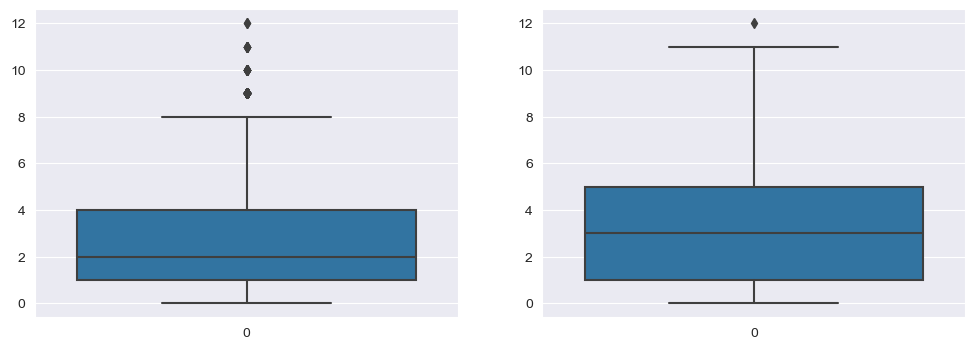

In [32]:
# plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot((svc_dev_pred != Y_dev.to_numpy().astype(int)).sum(axis=1), ax=ax[0])
sns.boxplot((svc_test_pred != Y_test.to_numpy().astype(int)).sum(axis=1), ax=ax[1])
ax[0].set_label("SVC Performance - Development Set")
ax[1].set_label("SVC Performance - Test Set")

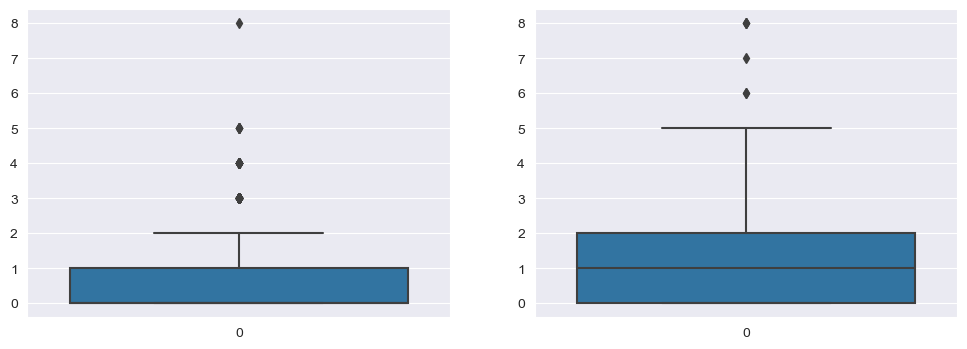

In [33]:
# plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot((rf_dev_pred != Y_dev.to_numpy().astype(int)).sum(axis=1), ax=ax[0])
sns.boxplot((rf_test_pred != Y_test.to_numpy().astype(int)).sum(axis=1), ax=ax[1])
ax[0].set_label("Random Forest Performance - Development Set")
ax[1].set_label("Random Fores Performance - Test Set")

Other evaluation metrics.

Example-based
1. Hamming loss: computes the proportion of incorrectly predicted labels to the total number of labels. For a multilabel classification, we compute the number of False Positives and False Negative per instance and then average it over the total number of training instances.
2. Exact Match Ratio (EMR): An extension of single label classification accuracy. The drawback is that it does not account for partially correct labels.
3. Example-Based Accuracy & Precision: The proportion of predicted correct labels to the total number of predicted labels, averaged over all instances.


In [37]:
N_example, N_class = rf_test_pred.shape

In [45]:
#Exact Match Ratio (EMR) is just accuracy

In [46]:
#Example-Based Accuracy Precision
print('Example-Based Accuracy Precision: ', np.mean(np.sum(rf_test_pred == Y_test.to_numpy().astype(int), axis=1)/N_class))


Example-Based Accuracy Precision:  0.9756500426257458


Label based evaluation metrics:

1. Macro Averaged Accuracy Precision Recall: calcu- late on individual class label and then averaged over all classes.
2. Micro Averaged Accuracy Precision Recall: calculate globally over all instances and all class labels.

In [47]:
#Precision = TruePositives / (TruePositives + FalsePositives) 
#Recall = TruePositives / (TruePositives + FalseNegatives) 

In [48]:
def TP_FP_FN(p,y):
    #by class
    TP_list = []
    FP_list = []
    FN_list = []
    for j in range(len(p[0])):
        TP,FP,FN = 0,0,0
        for i in range(len(p)):
            if y[i][j]==1 and p[i][j]==1:
                TP += 1
            if y[i][j]==0 and p[i][j]==1:
                FP += 1
            if y[i][j]==1 and p[i][j]==0:
                FN += 1
        TP_list.append(TP)
        FP_list.append(FP)
        FN_list.append(FN)
    return np.array(TP_list),np.array(FP_list),np.array(FN_list)

TP_list,FP_list,FN_list = TP_FP_FN(rf_test_pred, Y_test.to_numpy().astype(int))

In [49]:
# average over all classes
# Macro_precision
# warning message comes from denominator being 0 for some classes
# use np.nanmean to exclude those cases when computing average over classes
print("Random Forest Label based Macro precision: ", np.nanmean(TP_list/(TP_list+FP_list)))
# Macro_recall
print("Random Forest Label based Macro recall: ", np.nanmean(TP_list/(TP_list+FN_list)))
# Question: low recall, high False Negatives

Random Forest Label based Macro precision:  0.6349908098028398
Random Forest Label based Macro recall:  0.3126695139973967


/var/folders/s5/5644r9y14m5f6br6fghs08hc0000gn/T/ipykernel_6209/2176848013.py:5: RuntimeWarning: invalid value encountered in divide
  print("Random Forest Label based Macro precision: ", np.nanmean(TP_list/(TP_list+FP_list)))
/var/folders/s5/5644r9y14m5f6br6fghs08hc0000gn/T/ipykernel_6209/2176848013.py:7: RuntimeWarning: invalid value encountered in divide
  print("Random Forest Label based Macro recall: ", np.nanmean(TP_list/(TP_list+FN_list)))


In [51]:
# globally over all data points
# Micro_precision
print("Random Forest Global Micro precision: ",sum(TP_list)/(sum(TP_list+FP_list)))
# Micro_recall
print("Random Forest Global Micro recall: ", sum(TP_list)/(sum(TP_list+FN_list)))


Random Forest Global Micro precision:  0.6705882352941176
Random Forest Global Micro recall:  0.39790575916230364


In [52]:
TP_list, FP_list, FN_list = TP_FP_FN(svc_test_pred, Y_test.to_numpy().astype(int))
# average over all classes
# Macro_precision
# warning message comes from denominator being 0 for some classes
# use np.nanmean to exclude those cases when computing average over classes
print("SVC Label based Macro precision: ", np.nanmean(TP_list/(TP_list+FP_list)))
# Macro_recall
print("SVC Label based Macro recall: ", np.nanmean(TP_list/(TP_list+FN_list)))
# Question: low recall, high False Negatives
# globally over all data points
# Micro_precision
print("SVC Global Micro precision: ",sum(TP_list)/(sum(TP_list+FP_list)))
# Micro_recall
print("SVC Global Micro recall: ", sum(TP_list)/(sum(TP_list+FN_list)))


SVC Label based Macro precision:  0.2612638847875694
SVC Label based Macro recall:  0.6723222443183536
SVC Global Micro precision:  0.2554878048780488
SVC Global Micro recall:  0.731239092495637


/var/folders/s5/5644r9y14m5f6br6fghs08hc0000gn/T/ipykernel_6209/176769267.py:8: RuntimeWarning: invalid value encountered in divide
  print("SVC Label based Macro recall: ", np.nanmean(TP_list/(TP_list+FN_list)))
